In [2]:
import pandas as pd
from datetime import datetime

The dataset reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain.

You can download the dataset from the UCI Machine Learning Repository.

### Data Preparation

In [18]:
dataset_path = "data/raw_beijing_air_data.csv"

# combines the date columns (year, month, day, hour) into a single date-time value
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv(dataset_path,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

# remove the 'No' column
dataset.drop('No', axis=1, inplace=True)

# rename the columns to something more readable
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

# rename the index column to 'date'
dataset.index.name = 'date'

# replace all NaN values with 0 in pollution column
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

# summarize first 5 rows
print(dataset.head(5))

# save to file
clean_dataset_path = 'data/beijing-pm25-data-set/pollution.csv'
dataset.to_csv(clean_dataset_path)

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


Loads the new “pollution.csv” file and plots each series as a separate subplot, except wind speed dir, which is categorical.

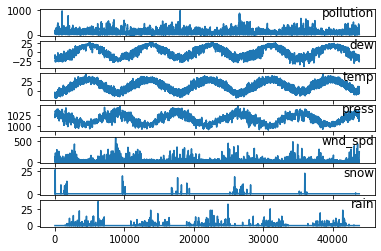

In [19]:
from matplotlib import pyplot

# load dataset
dataset = pd.read_csv(clean_dataset_path, header=0, index_col=0)
values = dataset.values

# specify columns to plot (skip 4 which is the win dir)
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [86]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# shift given columns by 'shift' amount
def shift_cols(data, col_list, shift, dropnan=True):
    df = pd.DataFrame(data)
    
    # shift columns in 'col_list' by 'shift' amount
    for i in col_list:
        df[i] = df[i].shift(shift)    
    
    # drop rows with NaN values
    if dropnan:
        df.dropna(inplace=True)
    return df


# load dataset
values = dataset.values

# integer encode wind direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
pd.DataFrame(scaled).head()

'''
our supervising learning problem is predicting the pollution at time t
given the previous time steps features (including pollution itself) 
''' 
# shift all columns to t-1 and create a new column at end for pollution at time t
reframed = shift_cols(scaled, [0,1,2,3,4,5,6,7], 1)
reframed['label'] = reframed[0].shift(-1)
reframed.dropna(inplace=True)

print(reframed.head(20))

           0         1         2         3         4         5         6    7  \
1   0.129779  0.352941  0.245902  0.527273  0.666667  0.002290  0.000000  0.0   
2   0.148893  0.367647  0.245902  0.527273  0.666667  0.003811  0.000000  0.0   
3   0.159960  0.426471  0.229508  0.545454  0.666667  0.005332  0.000000  0.0   
4   0.182093  0.485294  0.229508  0.563637  0.666667  0.008391  0.037037  0.0   
5   0.138833  0.485294  0.229508  0.563637  0.666667  0.009912  0.074074  0.0   
6   0.109658  0.485294  0.213115  0.563637  0.666667  0.011433  0.111111  0.0   
7   0.105634  0.485294  0.213115  0.581818  0.666667  0.014492  0.148148  0.0   
8   0.124748  0.485294  0.229508  0.600000  0.666667  0.017551  0.000000  0.0   
9   0.120724  0.470588  0.213115  0.600000  0.666667  0.020610  0.000000  0.0   
10  0.132797  0.485294  0.229508  0.618183  0.666667  0.023669  0.000000  0.0   
11  0.140845  0.485294  0.229508  0.636364  0.666667  0.029018  0.037037  0.0   
12  0.152918  0.470588  0.22

In [104]:
# we have a total of 5 years of data, train on 4 years and test on 1 year
# split into train and test sets
values = reframed.values
n_train_years = 4
n_train_hours = 365 * 24 * n_train_years
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 1, 8) (35040,) (8758, 1, 8) (8758,)


### Build and train LSTM model to predict the pollution
We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 20 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [105]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 35040 samples, validate on 8758 samples
Epoch 1/20
 - 3s - loss: 0.0353 - val_loss: 0.0325
Epoch 2/20
 - 1s - loss: 0.0142 - val_loss: 0.0141
Epoch 3/20
 - 1s - loss: 0.0140 - val_loss: 0.0132
Epoch 4/20
 - 1s - loss: 0.0140 - val_loss: 0.0131
Epoch 5/20
 - 1s - loss: 0.0139 - val_loss: 0.0131
Epoch 6/20
 - 1s - loss: 0.0139 - val_loss: 0.0132
Epoch 7/20
 - 1s - loss: 0.0139 - val_loss: 0.0134
Epoch 8/20
 - 1s - loss: 0.0139 - val_loss: 0.0133
Epoch 9/20
 - 1s - loss: 0.0138 - val_loss: 0.0134
Epoch 10/20
 - 1s - loss: 0.0139 - val_loss: 0.0133
Epoch 11/20
 - 1s - loss: 0.0139 - val_loss: 0.0135
Epoch 12/20
 - 1s - loss: 0.0139 - val_loss: 0.0136
Epoch 13/20
 - 1s - loss: 0.0138 - val_loss: 0.0138
Epoch 14/20
 - 1s - loss: 0.0139 - val_loss: 0.0137
Epoch 15/20
 - 1s - loss: 0.0138 - val_loss: 0.0136
Epoch 16/20
 - 1s - loss: 0.0138 - val_loss: 0.0136
Epoch 17/20
 - 1s - loss: 0.0138 - val_loss: 0.0136
Epoch 18/20
 - 1s - loss: 0.0138 - val_loss: 0.0135
Epoch 19/20
 - 1s - loss

In [106]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


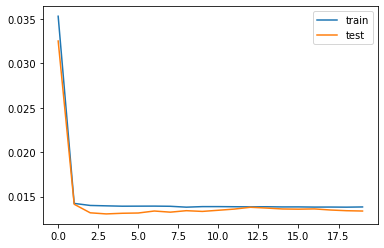

In [107]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Evaluate model

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [108]:
from math import sqrt
from numpy import concatenate

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 24.837
